In [45]:
import os
import cv2
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

In [46]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras import layers, Sequential, datasets, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import keras.src.saving
import warnings
warnings.filterwarnings('ignore')

In [47]:
# Task 1: Import images with labels and print in a tabular format
data_folder = "/home/dhawi/Documents/dataset"
dataset = data_folder + "/AI_project"
model_folder = "/home/dhawi/Documents/model"
history_folder = "/home/dhawi/Documents/History"

In [48]:
from keras import ops
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.seed_generator = keras.random.SeedGenerator(1337)

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = ops.shape(z_mean)[0]
        dim = ops.shape(z_mean)[1]
        epsilon = keras.random.normal(shape=(batch, dim), seed=self.seed_generator)
        return z_mean + ops.exp(0.5 * z_log_var) * epsilon

In [49]:
def generate_images(generator, encoder, decoder, num_images):
    noise = tf.random.normal((num_images, 1024, 1))
    noise = decoder.predict(noise)
    noise = encoder.predict(noise)[2]
    noise = tf.convert_to_tensor(noise)
    generated_images = generator.predict(noise)
    # generated_images = (generated_images * 127.5 + 127.5).astype(np.uint8)  # Rescale to [0, 255]
    return generated_images

In [50]:
caries_gan_generator = keras.src.saving.load_model(model_folder + "/fyp_caries_EDGAN1024_encoder.h5", compile=False)
gingivitis_gan_generator = keras.src.saving.load_model(model_folder + "/fyp_gingivitis_EDGAN1024_encoder.h5", compile=False)
wsl_gan_generator = keras.src.saving.load_model(model_folder + "/fyp_wsls_EDGAN1024_encoder.h5", compile=False)

In [51]:
caries_encoder = keras.src.saving.load_model(model_folder + "/fyp_caries_vae1024_encoder.h5", custom_objects={'Sampling': Sampling}, compile=False)
caries_decoder = keras.src.saving.load_model(model_folder + "/fyp_caries_vae1024_decoder.h5", custom_objects={'Sampling': Sampling}, compile=False)
gingivitis_encoder = keras.src.saving.load_model(model_folder + "/fyp_gingivitis_vae1024_encoder.h5", custom_objects={'Sampling': Sampling}, compile=False)
gingivitis_decoder = keras.src.saving.load_model(model_folder + "/fyp_gingivitis_vae1024_decoder.h5", custom_objects={'Sampling': Sampling}, compile=False)
wsl_encoder = keras.src.saving.load_model(model_folder + "/fyp_wsls_vae1024_encoder.h5", custom_objects={'Sampling': Sampling}, compile=False)
wsl_decoder = keras.src.saving.load_model(model_folder + "/fyp_wsls_vae1024_decoder.h5", custom_objects={'Sampling': Sampling}, compile=False)

In [52]:
num_images_to_generate = 10

generated_caries_images = generate_images(caries_gan_generator, caries_encoder, caries_decoder, num_images_to_generate)
generated_gingivitis_images = generate_images(gingivitis_gan_generator, gingivitis_encoder, gingivitis_decoder, num_images_to_generate)
generated_wsl_images = generate_images(wsl_gan_generator, wsl_encoder, wsl_decoder, num_images_to_generate)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 696ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 634ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 680ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


In [53]:
# Load the trained ResNet model
trained_resnet_model = tf.keras.models.load_model('/home/dhawi/PycharmProjects/pythonProject/FYP deployment/RESNET/keras_best_model.keras')

def classify_images(model, images):
    predictions = model.predict(images)
    confidences = np.max(predictions, axis=1)
    predicted_labels = np.argmax(predictions, axis=1)
    return predicted_labels, confidences

In [54]:
# Classify the generated images
caries_labels, caries_confidences = classify_images(trained_resnet_model, generated_caries_images)
gingivitis_labels, gingivitis_confidences = classify_images(trained_resnet_model, generated_gingivitis_images)
wsl_labels, wsl_confidences = classify_images(trained_resnet_model, generated_wsl_images)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


In [55]:
fixed_noise = tf.random.normal((60, 1024,1))
noise = caries_decoder.predict(fixed_noise)
noise = caries_encoder.predict(noise)[2]
noise = tf.convert_to_tensor(noise)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 695ms/step


In [56]:
def show_images(images):
    for i in range(4):
        plt.subplot(4, 5, i + 1)
        plt.imshow(images[i])
        plt.xticks([])
        plt.yticks([])
    plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


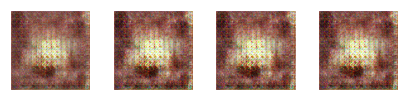

In [57]:
y_pred = caries_gan_generator.predict(noise)
show_images(y_pred)

In [58]:
trained_resnet_model.predict(generated_caries_images)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


array([[0.36344966, 0.2669622 , 0.36958808],
       [0.35938224, 0.26751384, 0.37310395],
       [0.36469123, 0.26772627, 0.36758253],
       [0.3583363 , 0.26739025, 0.37427348],
       [0.36274305, 0.26722276, 0.37003416],
       [0.36114657, 0.26718313, 0.3716704 ],
       [0.36396962, 0.26749644, 0.3685339 ],
       [0.36141816, 0.26717654, 0.37140527],
       [0.36530325, 0.26749393, 0.36720285],
       [0.3598338 , 0.26713157, 0.37303463]], dtype=float32)

In [59]:
trained_resnet_model.predict(generated_gingivitis_images)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


array([[0.36129573, 0.26550788, 0.37319636],
       [0.35924515, 0.26544604, 0.37530887],
       [0.36009255, 0.2653277 , 0.37457976],
       [0.3608229 , 0.2656701 , 0.37350696],
       [0.36819476, 0.26649317, 0.36531198],
       [0.36136204, 0.26579785, 0.37284008],
       [0.34780383, 0.26573065, 0.38646546],
       [0.35933283, 0.26523817, 0.37542903],
       [0.36556873, 0.26562014, 0.3688111 ],
       [0.3586095 , 0.26496786, 0.37642267]], dtype=float32)

In [60]:
trained_resnet_model.predict(generated_wsl_images)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


array([[0.35755304, 0.26945558, 0.3729914 ],
       [0.3592863 , 0.26918074, 0.37153298],
       [0.35907277, 0.2690206 , 0.37190667],
       [0.36106738, 0.2691149 , 0.3698177 ],
       [0.36377212, 0.26917994, 0.36704794],
       [0.3575954 , 0.26908416, 0.3733204 ],
       [0.36078867, 0.26912326, 0.37008804],
       [0.36337766, 0.26885325, 0.36776903],
       [0.36212945, 0.26905262, 0.36881793],
       [0.35785052, 0.26930752, 0.37284195]], dtype=float32)

In [61]:
caries_confidences

array([0.36958808, 0.37310395, 0.36758253, 0.37427348, 0.37003416,
       0.3716704 , 0.3685339 , 0.37140527, 0.36720285, 0.37303463],
      dtype=float32)

In [62]:
wsl_labels

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [63]:
caries_labels

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [64]:
confidence_threshold = 0.60  # Example threshold, adjust based on your needs

def filter_images(images, labels, confidences, true_label, threshold):
    mask = (labels == true_label) & (confidences >= threshold)
    return images[mask]

In [65]:
filtered_caries_images = filter_images(generated_caries_images, caries_labels, caries_confidences, 0, confidence_threshold)
filtered_gingivitis_images = filter_images(generated_gingivitis_images, gingivitis_labels, gingivitis_confidences, 1, confidence_threshold)
filtered_wsl_images = filter_images(generated_wsl_images, wsl_labels, wsl_confidences, 2, confidence_threshold)

In [66]:
filtered_caries_images.shape, filtered_gingivitis_images.shape, filtered_wsl_images.shape

((0, 128, 128, 3), (0, 128, 128, 3), (0, 128, 128, 3))

In [67]:
import os
# Function to get image file paths and corresponding labels
def get_image_paths_and_labels(data_dir):
    image_paths = []
    labels = []
    class_names = sorted(os.listdir(data_dir))
    
    for label, class_name in enumerate(class_names):
        class_dir = os.path.join(data_dir, class_name)
        if os.path.isdir(class_dir):
            for sub_dir in os.listdir(class_dir):
                sub_dir_path = os.path.join(class_dir, sub_dir)
                if os.path.isdir(sub_dir_path):
                    for img_name in os.listdir(sub_dir_path):
                        img_path = os.path.join(sub_dir_path, img_name)
                        if os.path.isfile(img_path):
                            img = cv2.imread(img_path)
                            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                            img = cv2.resize(img, (128, 128))
                            image_paths.append(img/255.0)
                            labels.append(label)
    
    return np.array(image_paths), labels, class_names

In [68]:
# Load and preprocess images
def load_image(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [128, 128])
    return image, label

In [69]:
def load_original_images_and_labels(dataset_dir):
    image_paths, labels, class_names = get_image_paths_and_labels(dataset_dir)
    images = image_paths
    labels = np.array(labels)
    return images, labels, class_names

In [70]:
original_images, original_labels, class_names = load_original_images_and_labels(dataset)

# Assuming class indices are:
# caries: 0, gingivitis: 1, wsl: 2

# Create labels for generated images
generated_caries_labels = np.array([0 for _ in range(num_images_to_generate)])
generated_gingivitis_labels = np.array([1 for _ in range(num_images_to_generate)])
generated_wsl_labels = np.array([2 for _ in range(num_images_to_generate)])

# Combine original and generated images and labels
augmented_images = np.concatenate([original_images, generated_caries_images, generated_gingivitis_images, generated_wsl_images], axis=0)
augmented_labels = np.concatenate([original_labels, generated_caries_labels, generated_gingivitis_labels, generated_wsl_labels], axis=0)

In [71]:
generated_caries_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [72]:
augmented_labels

array([0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [73]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
# Initialize Stratified K-Fold Cross-Validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Prepare to collect metrics
val_accuracies = []
all_labels = []
all_predictions = []

for train_index, val_index in kf.split(augmented_images, augmented_labels):
    train_images, val_images = augmented_images[train_index], augmented_images[val_index]
    train_labels, val_labels = augmented_labels[train_index], augmented_labels[val_index]

    # Compute class weights
    class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
    class_weights = {i: class_weights[i] for i in range(len(class_weights))}
    
    # Create ImageDataGenerators for training and validation
    train_datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    
    val_datagen = ImageDataGenerator()
    
    # Create training and validation generators
    train_generator = train_datagen.flow(train_images, train_labels, batch_size=32)
    val_generator = val_datagen.flow(val_images, val_labels, batch_size=32)
    
    # Load the ResNet50 model pre-trained on ImageNet
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

    # Freeze the base model
    base_model.trainable = False

    # Add custom layers on top of the base model
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(3, activation='softmax')(x)  # 3 classes: caries, gingivitis, wsl

    # Create the final model
    model = Model(inputs=base_model.input, outputs=predictions)

    # Compile the model
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Callbacks
    checkpoint = ModelCheckpoint('best_EDGAN_model.keras', monitor='val_loss', save_best_only=True, mode='min')
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    keras.backend.clear_session()
    # Train the model
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=50,
        class_weight=class_weights,
        callbacks=[checkpoint, early_stopping]
    )

    # Evaluate the model on the validation set
    val_loss, val_accuracy = model.evaluate(val_generator)
    val_accuracies.append(val_accuracy)

    # Generate predictions for the validation set
    val_pred_probs = model.predict(val_generator)
    val_preds = np.argmax(val_pred_probs, axis=1)
    
    # Collect labels and predictions for confusion matrix
    all_labels.extend(val_labels)
    all_predictions.extend(val_preds)

Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 3s/step - accuracy: 0.3661 - loss: 1.1612 - val_accuracy: 0.3333 - val_loss: 1.1424
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.2511 - loss: 1.1852 - val_accuracy: 0.3333 - val_loss: 1.1755
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 521ms/step - accuracy: 0.3803 - loss: 1.1783 - val_accuracy: 0.3333 - val_loss: 1.1095
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.2591 - loss: 1.1389 - val_accuracy: 0.3333 - val_loss: 1.1346
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.3603 - loss: 1.1247 - val_accuracy: 0.5000 - val_loss: 1.1307
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.3177 - loss: 1.1437 - val_accuracy: 0.3333 - val_loss: 1.1207
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 495ms/step - accuracy: 0.2677 - loss: 1.1262 - val_accuracy: 0.3333 - val_loss: 1.1062
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.3442 - loss: 1.1267 - val_accuracy: 0.3333 - val_loss: 1.1177


In [74]:
# Print average validation accuracy
print(f'Average validation accuracy: {np.mean(val_accuracies):.2f}')

Average validation accuracy: 0.41


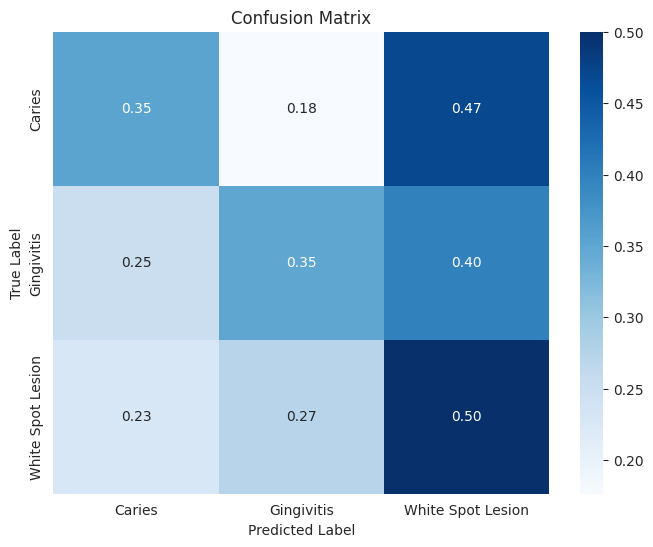

In [75]:
# Calculate and plot confusion matrix
cm = confusion_matrix(all_labels, all_predictions)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [76]:
# Print classification report
print(classification_report(all_labels, all_predictions, target_names=class_names))

                   precision    recall  f1-score   support

           Caries       0.38      0.35      0.36        17
       Gingivitis       0.44      0.35      0.39        20
White Spot Lesion       0.41      0.50      0.45        22

         accuracy                           0.41        59
        macro avg       0.41      0.40      0.40        59
     weighted avg       0.41      0.41      0.40        59



In [77]:
# Plotting the training history (optional)
def plot_training_history(history):
    plt.figure(figsize=(12, 4))
    
    # Plot training & validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Plot training & validation loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.show()

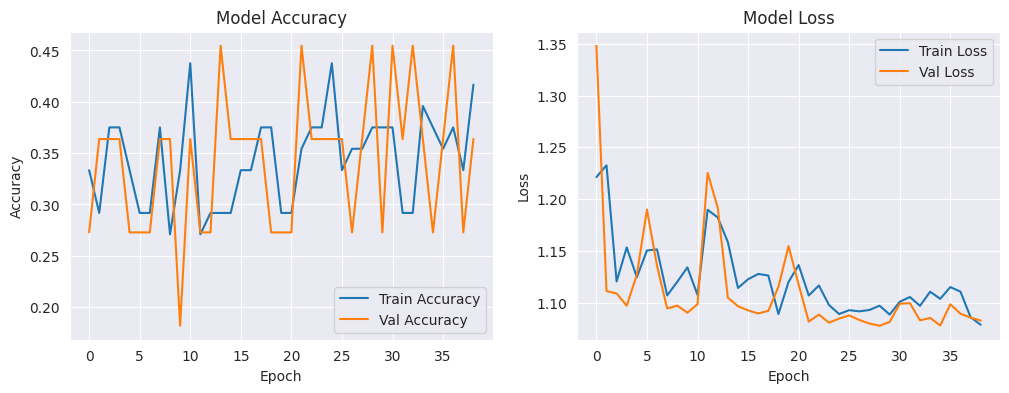

In [78]:
# Plotting the training history (optional)
plot_training_history(history)